In [5]:
import pandas as pd
import numpy as np
from arch import arch_model
import pandas_datareader as web
import datetime as dt
import matplotlib.pyplot as plt
import seaborn
import sys
import itertools
import math

%matplotlib inline

In [6]:
## Get VIX and SPX data
start = pd.to_datetime('1989-01-01')
end = pd.datetime.today()

mkt = '^GSPC'
MKT = (web.DataReader([mkt,'^VIX'], 'yahoo', start, end)['Adj Close']
      .resample('MS') # month start b/c FED data is month start
       .mean()
       .rename(columns={mkt:'SPX','^VIX':'VIX'})
       .assign(SPX_returns=lambda x: np.log(x['SPX']/x['SPX'].shift(1)))
       .assign(VIX_returns=lambda x: np.log(x['VIX']/x['VIX'].shift(1)))
       ).dropna()

MKT['SPX_returns'] *= 100
MKT['VIX_returns'] *= 100
MKT.head()

,SPX,VIX,SPX_returns,VIX_returns
Date,,,,
1990-02-01,330.452635,23.262632,-2.839939,-0.363189
1990-03-01,338.465000,20.062273,2.395735,-14.800723
1990-04-01,338.177998,21.403500,-0.084831,6.471340
1990-05-01,350.250001,18.097727,3.507481,-16.776810
1990-06-01,360.386667,16.822381,2.853034,-7.307617


In [13]:
def Calc_Implied_Vol(x0):
    '''
    Calculate implied vol and SSE between implied and actual vol.
    '''
    p_, q_ = x0
    p_, q_ = math.ceil(p_), math.ceil(q_)
    am = arch_model(MKT['SPX_returns'], vol='GARCH', p=p_, q=q_) #GARCH model

    index = MKT.index
    num_months = len(MKT)-1  # number of mos b/w start and end
    forecasts = {}
    end_loc = np.where(index >= '1990-4-1')[0].min()
    
    for i in range(num_months):
    #     sys.stdout.write('.')
    #     sys.stdout.flush()
        res = am.fit(first_obs=i, last_obs=i+end_loc, disp='off') # predicting one period ahead
        temp = res.forecast(horizon=1).variance
        fcast = temp.iloc[i+end_loc-1]
        forecasts[fcast.name] = fcast

    df_imply_vol = pd.DataFrame(forecasts).T

    return np.sum(np.square(np.subtract(df_imply_vol.values, MKT['VIX'].values)))

In [14]:
## Using cross-validation, find optimal value of p and q to run GARCH model with
## optimal values are p=3, q=4
p,q = 0,0
min_sse = np.Inf
for val_combo in list(itertools.permutations([1,2,3,4], 2)):
    curr_min = Calc_Implied_Vol(val_combo)
    if curr_min < min_sse:
        min_sse = curr_min
        p,q = val_combo
        
print (p,q)

3 4


In [16]:
am = arch_model(MKT['SPX_returns'], vol='GARCH', p=3, q=4) #GARCH model

index = MKT.index
num_months = len(MKT)-1  # number of mos b/w start and end
forecasts = {}
end_loc = np.where(index >= '1990-4-1')[0].min()

for i in range(num_months):
#     sys.stdout.write('.')
#     sys.stdout.flush()
    res = am.fit(first_obs=i, last_obs=i+end_loc, disp='off') # predicting one period ahead
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i+end_loc-1]
    forecasts[fcast.name] = fcast

df_imply_vol = pd.DataFrame(forecasts).T

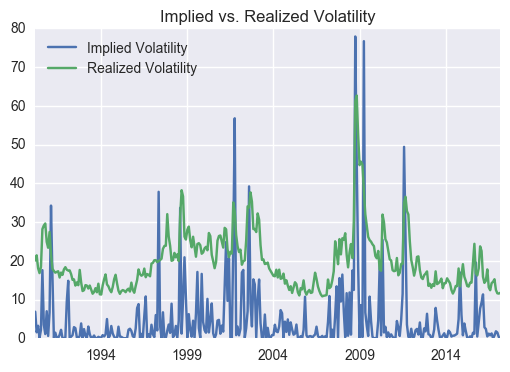

In [18]:
df_vol = pd.DataFrame([df_imply_vol['h.1'], MKT['VIX']]).T.dropna()
df_vol.columns = ['Implied Volatility', 'Realized Volatility']

df_vol.plot()
plt.title('Implied vs. Realized Volatility')
plt.legend(loc='best')

In [19]:
df_vol.to_csv('Implied_and_Realized_Vol.csv')